In [276]:
#didn't want to use notebook space for package installation logs so,
#writing to a log file to see in case there is an error
!apt install -y swig >> apt_logs.txt
!pip install smac[all] >> pip_logs.txt



E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# CASH PROBLEM Solved + BEST MODEL PERF

In [ ]:
import numpy as np
import pandas as pd
from typing import Callable
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from smac.scenario.scenario import Scenario
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.facade.smac_bo_facade import SMAC4BO
from smac.initial_design.random_configuration_design import RandomConfigurations
from smac.optimizer.acquisition import LCB, EI, PI
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformIntegerHyperparameter

# Meta-feature functions
def extract_meta_features(X, y):
    return {
        "n_samples": X.shape[0],
        "n_features": X.shape[1],
        "sparsity": float(np.mean(X == 0)),
        "class_imbalance": np.max(np.bincount(y)) / len(y)
    }

meta_feature_db = [
    {"meta": {"n_samples": 150, "n_features": 4, "sparsity": 0.0, "class_imbalance": 0.33}, "config": {"model": "rf"}},
    {"meta": {"n_samples": 1000, "n_features": 50, "sparsity": 0.1, "class_imbalance": 0.6}, "config": {"model": "mlp"}}
]

def find_closest_config(meta, db):
    def distance(m1, m2):
        return sum(abs(m1[k] - m2[k]) for k in m1)
    closest = min(db, key=lambda entry: distance(meta, entry["meta"]))
    return closest["config"]

# Config space
cs = ConfigurationSpace()
model = CategoricalHyperparameter("model", ["rf", "mlp", "knn", "nb", "logreg", "svm", "gb"])
cs.add_hyperparameter(model)

# Hyperparameters for each model
rf_n_estimators = UniformIntegerHyperparameter("rf_n_estimators", 10, 500, default_value=100)
rf_max_depth = UniformIntegerHyperparameter("rf_max_depth", 1, 20, default_value=10)
mlp_hidden_layer_sizes = CategoricalHyperparameter("mlp_hidden_layer_sizes", ["(100,)", "(50, 50)", "(200, 100)"], default_value="(100,)")
mlp_max_iter = UniformIntegerHyperparameter("mlp_max_iter", 100, 1000, default_value=300)
svm_C = UniformIntegerHyperparameter("svm_C", 1, 10, default_value=1)
svm_kernel = CategoricalHyperparameter("svm_kernel", ["linear", "rbf"], default_value="rbf")
gb_n_estimators = UniformIntegerHyperparameter("gb_n_estimators", 50, 200, default_value=100)
gb_max_depth = UniformIntegerHyperparameter("gb_max_depth", 1, 20, default_value=3)

cs.add_hyperparameter(rf_n_estimators)
cs.add_hyperparameter(rf_max_depth)
cs.add_hyperparameter(mlp_hidden_layer_sizes)
cs.add_hyperparameter(mlp_max_iter)
cs.add_hyperparameter(svm_C)
cs.add_hyperparameter(svm_kernel)
cs.add_hyperparameter(gb_n_estimators)
cs.add_hyperparameter(gb_max_depth)

# Make objective function with scoring
def make_objective(X, y):
    def objective(cfg):
        cfg = cfg.get_dictionary()
        models = {
            "rf": [('rf', RandomForestClassifier(n_estimators=cfg["rf_n_estimators"], max_depth=cfg["rf_max_depth"])),
                   ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "mlp": [('mlp', MLPClassifier(hidden_layer_sizes=eval(cfg["mlp_hidden_layer_sizes"]), max_iter=cfg["mlp_max_iter"])),
                    ('nb', GaussianNB()), ('svc', SVC(probability=True))],
            "knn": [('knn', KNeighborsClassifier(n_neighbors=5)), ('logreg', LogisticRegression(max_iter=1000)), ('svc', SVC(probability=True))],
            "nb": [('nb', GaussianNB()), ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
            "logreg": [('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier()), ('nb', GaussianNB())],
            "svm": [('svc', SVC(C=cfg["svm_C"], kernel=cfg["svm_kernel"], probability=True)), ('rf', RandomForestClassifier())],
            "gb": [('gb', GradientBoostingClassifier(n_estimators=cfg["gb_n_estimators"], max_depth=cfg["gb_max_depth"])),
                   ('logreg', LogisticRegression(max_iter=1000)), ('rf', RandomForestClassifier())],
        }[cfg["model"]]

        pipe = make_pipeline(StandardScaler(),
                             StackingClassifier(estimators=models, final_estimator=LogisticRegression()))

        scores = cross_val_score(pipe, X, y, cv=StratifiedKFold(n_splits=5), n_jobs=-1)
        return 1 - np.mean(scores)
    return objective

# Run SMAC
def optimizer_trial(surrogate_model: str, config_space: ConfigurationSpace, obj_function: Callable, acquisition_type: str, n_iter=30, init_points=10, seed=42):
    scenario = Scenario({
        "run_obj": "quality",
        "runcount-limit": n_iter,
        "cs": config_space,
        "deterministic": "true",
        "abort_on_first_run_crash": False,
        "always_race_default": False,
        "wallclock-limit": 1200,
        "cutoff": 120,
    })

    acquisition_map = {"LCB": LCB, "EI": EI, "PI": PI}
    _acquisition = acquisition_map[acquisition_type]

    smac_class = SMAC4HPO if surrogate_model == 'rf' else SMAC4BO
    smac = smac_class(
        scenario=scenario, tae_runner=obj_function,
        rng=np.random.RandomState(seed),
        initial_design=RandomConfigurations,
        initial_design_kwargs={'n_configs_x_params': init_points, 'max_config_fracs': init_points / n_iter},
        acquisition_function=_acquisition
    )

    best_cfg = smac.optimize()
    return smac, best_cfg

def load_dataset_with_encoding(path_X, path_y):
    X_df = pd.read_csv(path_X)
    y_df = pd.read_csv(path_y)

    # Convert all object (string) columns in X to dummy variables
    X_encoded = pd.get_dummies(X_df)

    # If y is a string column (e.g., "good"/"bad"), convert to 0/1
    if y_df.dtypes[0] == object:
        y_encoded = y_df.iloc[:, 0].astype('category').cat.codes
    else:
        y_encoded = y_df.values.ravel()

    return X_encoded.values, y_encoded

# Load dataset, run all combos
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv")

}
#     "ilpd": ("Datasets/ilpd_X.csv", "Datasets/ilpd_y.csv")

results = {}

for name, (x_path, y_path) in datasets.items():
    print(f"\n📊 Dataset: {name}")
    X, y = load_dataset_with_encoding(x_path, y_path)

    meta = extract_meta_features(X, y)
    warmstart_dict = find_closest_config(meta, meta_feature_db)
    default_cfg = cs.get_default_configuration()
    for k, v in warmstart_dict.items():
        default_cfg[k] = v
    cs.default_configuration = lambda: default_cfg

    for surrogate in ["gp", "rf"]:
        for acq in ["EI", "PI", "LCB"]:
            key = f"{name}_{surrogate}_{acq}"
            print(f"🚀 Running: {key}")

            obj_fn = make_objective(X, y)
            smac_obj, best_cfg = optimizer_trial(
                surrogate_model=surrogate,
                config_space=cs,
                obj_function=obj_fn,
                acquisition_type=acq,
                n_iter=30,
                init_points=10,
                seed=42
            )

            # Models map with hyperparameters
            models = {
                "rf": RandomForestClassifier(n_estimators=best_cfg["rf_n_estimators"], max_depth=best_cfg["rf_max_depth"]),
                "mlp": MLPClassifier(hidden_layer_sizes=eval(best_cfg["mlp_hidden_layer_sizes"]), max_iter=best_cfg["mlp_max_iter"]),
                "svm": SVC(C=best_cfg["svm_C"], kernel=best_cfg["svm_kernel"], probability=True),
                "gb": GradientBoostingClassifier(n_estimators=best_cfg["gb_n_estimators"], max_depth=best_cfg["gb_max_depth"]),
                "logreg": LogisticRegression(max_iter=1000)
            }

            # Create stacking ensemble with top-performing models from SMAC
            best_models = [
                (model_name, models[model_name]) for model_name in models if best_cfg["model"] == model_name
            ]

            final_model = make_pipeline(
                StandardScaler(),
                StackingClassifier(estimators=best_models, final_estimator=LogisticRegression())
            )
            final_model.fit(X, y)
            y_pred = final_model.predict(X)
            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, average='weighted')
            rec = recall_score(y, y_pred, average='weighted')
            f1 = f1_score(y, y_pred, average='weighted')

            results[key] = {
                "smac": smac_obj,
                "best_config": best_cfg,
                "metrics": {
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1
                }
            }

# Final Summary
# print("\n🎯 Summary of All Experiments:")
# for key, val in results.items():
#     print(f"{key}: {val['best_config']}, "
#           f"Acc={val['metrics']['accuracy']:.3f}, "
#           f"Prec={val['metrics']['precision']:.3f}, "
#           f"Rec={val['metrics']['recall']:.3f}, "
#           f"F1={val['metrics']['f1']:.3f}")


INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2025-04-24_20:38:47_932340
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.random_configuration_design.RandomConfigurations:Running initial design for 10 configurations
INFO:smac.facade.smac_bo_facade.SMAC4BO:<class 'smac.facade.smac_bo_facade.SMAC4BO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



📊 Dataset: blood
🚀 Running: blood_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2232
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 16.006646 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 120.067236 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.530523 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.501824 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 80.046472 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_gp_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2246
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 15.611972 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 120.101155 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.553533 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.492444 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 82.559609 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_gp_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2219
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 15.983508 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 118.214942 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.508333 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.478187 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 86.086947 sec, available: 0.000010 sec)
INFO:smac.int

🚀 Running: blood_rf_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2272
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.297950 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 9.932212 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2259) is better than incumbent (0.2272) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_max_depth : 9 -> 7
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 133 -> 145
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(100,)' -> '(50, 50)'
IN

🚀 Running: blood_rf_PI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.331032 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 10.030088 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_max_depth : 9 -> 7
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 133 -> 145
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(100,)' -> '(50, 50)'
I

🚀 Running: blood_rf_LCB


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2259
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 5.325603 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 9.912579 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 8.433912 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 7.833433 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2246) is better than incumbent (0.2259) on 1 runs.
INFO:smac.intensification.intensification.Inten


📊 Dataset: credit
🚀 Running: credit_gp_EI


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.2400
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 27.082715 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 70.609065 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2400) is better than incumbent (0.2400) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  gb_n_estimators : 156 -> 126
INFO:smac.intensification.intensification.Intensifier:  mlp_hidden_layer_sizes : '(50, 50)' -> '(200, 100)'
INFO:smac.intensification.intensification.Intensifier:  mlp_max_iter : 728

In [480]:
print("\n🎯 Summary of All Experiments:")
for key, val in results.items():
    print(f"{key}: {val['best_config']}, "
          f"Acc={val['metrics']['accuracy']:.3f}, "
          f"Prec={val['metrics']['precision']:.3f}, "
          f"Rec={val['metrics']['recall']:.3f}, "
          f"F1={val['metrics']['f1']:.3f}")



🎯 Summary of All Experiments:
blood_gp_EI: Configuration:
  gb_max_depth, Value: 10
  gb_n_estimators, Value: 105
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 420
  model, Value: 'gb'
  rf_max_depth, Value: 16
  rf_n_estimators, Value: 453
  svm_C, Value: 4
  svm_kernel, Value: 'rbf'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
blood_gp_PI: Configuration:
  gb_max_depth, Value: 9
  gb_n_estimators, Value: 156
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 729
  model, Value: 'gb'
  rf_max_depth, Value: 6
  rf_n_estimators, Value: 84
  svm_C, Value: 6
  svm_kernel, Value: 'linear'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
blood_gp_LCB: Configuration:
  gb_max_depth, Value: 9
  gb_n_estimators, Value: 156
  mlp_hidden_layer_sizes, Value: '(50, 50)'
  mlp_max_iter, Value: 728
  model, Value: 'gb'
  rf_max_depth, Value: 6
  rf_n_estimators, Value: 84
  svm_C, Value: 6
  svm_kernel, Value: 'linear'
, Acc=0.762, Prec=0.581, Rec=0.762, F1=0.659
bl

Plot

In [491]:
# runhistory = bobt.runhistory

# # Get performance values (lower is better for SMAC by default)
# GP_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# # If you want to convert to accuracy:
# accuracies = [1 -c for c in GP_LCB_costs]

# # Plot it
# import matplotlib.pyplot as plt

# plt.plot(accuracies)
# plt.ylabel('Accuracy')
# plt.xlabel('Iterations')
# plt.title('SMAC Optimization Progress')
# plt.grid()
# plt.show()


In [492]:
# runhistory = smac_rf_pi_trial.runhistory

# # Get performance values (lower is better for SMAC by default)
# GP_LCB_costs = [runvalue.cost for runkey, runvalue in runhistory.data.items()]

# # If you want to convert to accuracy:
# accuracies = [1 - c for c in GP_LCB_costs]

# # Plot it
# import matplotlib.pyplot as plt

# plt.plot(accuracies)
# plt.ylabel('Accuracy')
# plt.xlabel('Iterations')
# plt.title('SMAC Optimization Progress')
# plt.grid()
# plt.show()


In [495]:
for key, val in results.items():
    smac_obj = val.get('smac')
    if smac_obj is None:
        continue

    runhistory = smac_obj.runhistory
    acc_scores = []
    for _, runvalue in runhistory.data.items():
        cost = runvalue.cost
        if cost > 1.0 or cost < 0.0:  # Ignore invalid costs (e.g., crashed runs)
            continue
        acc_scores.append(1 - cost)

    val["run_history"] = [
        {"iteration": i + 1, "metrics": {"accuracy": acc}} for i, acc in enumerate(acc_scores)
    ]


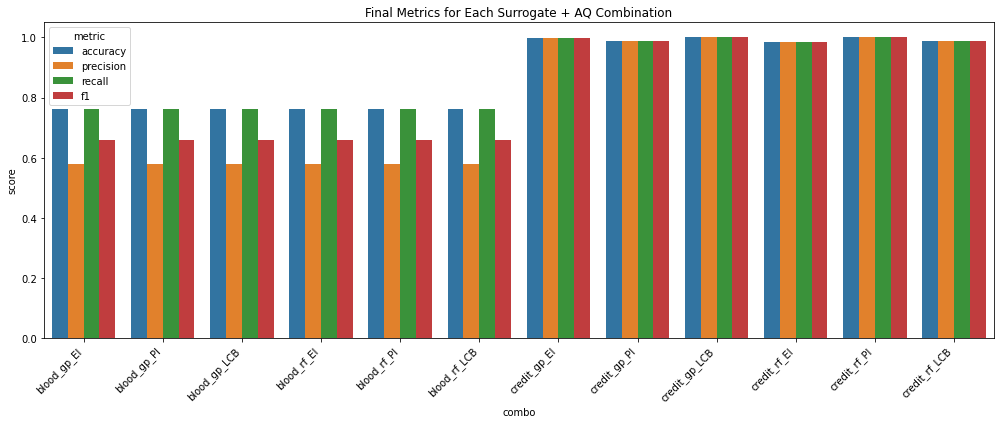

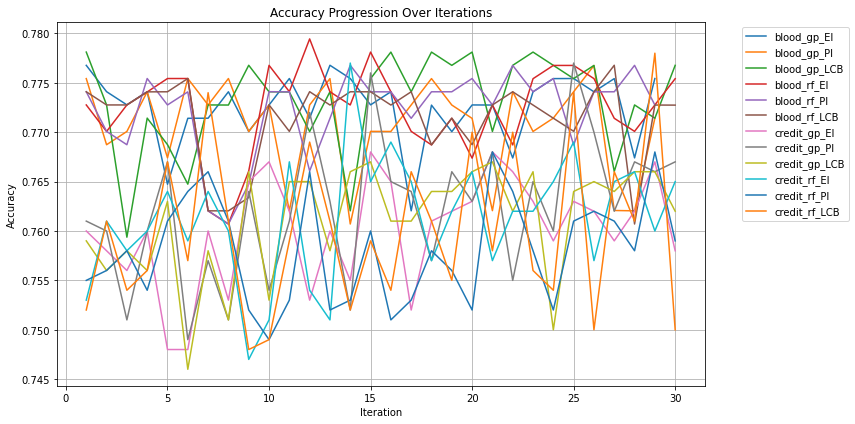

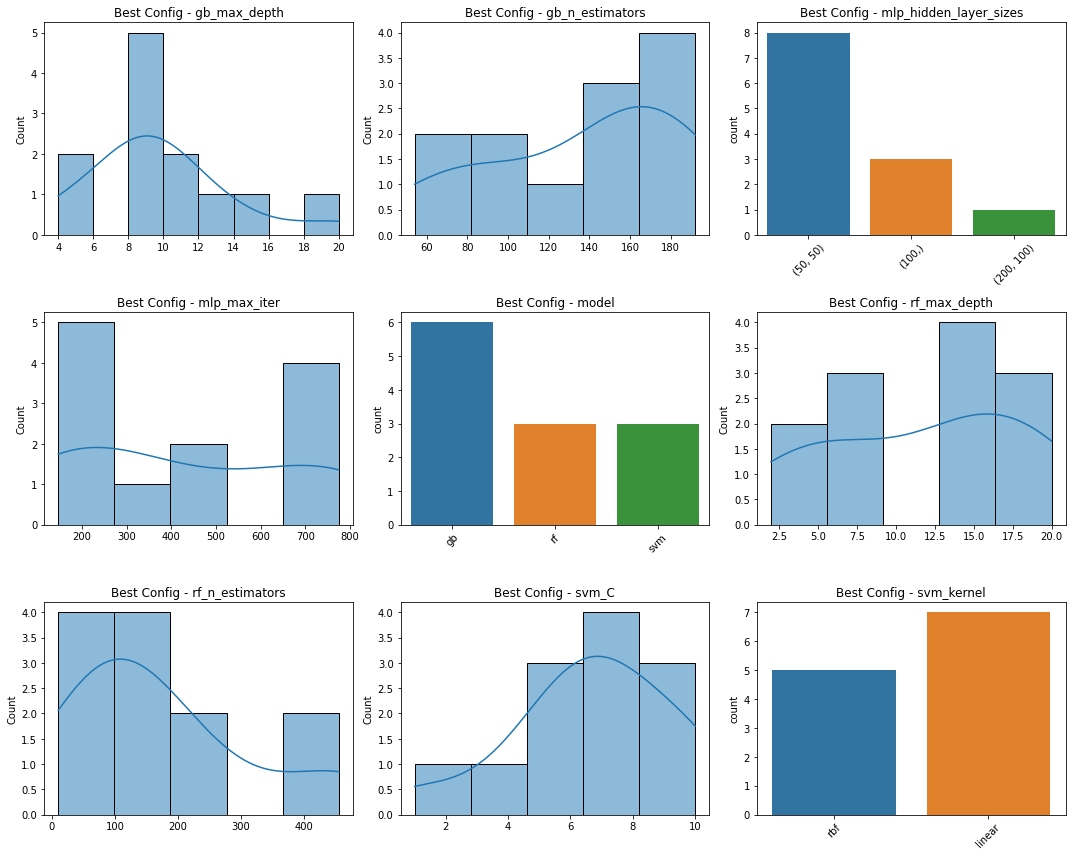

In [496]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import collections

# --- CONFIG: Toggle plot sections ---
PLOT_CONFIG_DISTRIBUTIONS = True  # Set to False to skip best_config distribution plot

# --- 1. Final Metrics Bar Plot ---
summary_data = []
for key, val in results.items():
    metrics = val['metrics']
    summary_data.append({
        'combo': key,
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1']
    })

df_summary = pd.DataFrame(summary_data)
df_melted = df_summary.melt(id_vars='combo', var_name='metric', value_name='score')

plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='combo', y='score', hue='metric')
plt.xticks(rotation=45, ha='right')
plt.title('Final Metrics for Each Surrogate + AQ Combination')
plt.tight_layout()
plt.show()

# --- 2. Iterative Accuracy Progress Plot ---

# Patch accuracy progression from SMAC runhistory if not already present
for key, val in results.items():
    if "run_history" not in val or not val["run_history"]:
        smac_obj = val.get('smac')
        if smac_obj is None:
            continue
        runhistory = smac_obj.runhistory
        acc_scores = [1 - runvalue.cost for _, runvalue in runhistory.data.items()]
        val["run_history"] = [
            {"iteration": i + 1, "metrics": {"accuracy": acc}} for i, acc in enumerate(acc_scores)
        ]

# Plot accuracy over iterations
plt.figure(figsize=(12, 6))
for key, val in results.items():
    history = val.get('run_history', [])
    if not history:
        continue
    iterations = [entry['iteration'] for entry in history]
    acc_scores = [entry['metrics']['accuracy'] for entry in history]
    plt.plot(iterations, acc_scores, label=key)

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Progression Over Iterations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# --- 3. Heatmap of F1 Score by Dataset vs Surrogate+AQ ---
heatmap_data = []
for key, val in results.items():
    try:
        dataset, surrogate, aq = key.split('-')
    except ValueError:
        continue  # skip malformed keys
    f1 = val['metrics']['f1']
    heatmap_data.append({
        'dataset': dataset,
        'combo': f'{surrogate}-{aq}',
        'f1': f1
    })

df_heat = pd.DataFrame(heatmap_data)
if not df_heat.empty:
    pivot = df_heat.pivot(index='dataset', columns='combo', values='f1')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("F1 Score Heatmap: Dataset vs Surrogate+AQ")
    plt.tight_layout()
    plt.show()

# --- 4. Distribution of Best Config Parameter Values ---
if PLOT_CONFIG_DISTRIBUTIONS:
    all_params = collections.defaultdict(list)

    for key, val in results.items():
        config = val.get('best_config', {})
        try:
            cfg_dict = config.get_dictionary()
        except AttributeError:
            cfg_dict = config  # fallback if it's already a dict
        for param, value in cfg_dict.items():
            all_params[param].append(value)

    # Plot distributions
    n_params = len(all_params)
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, (param, values) in enumerate(all_params.items()):
        ax = axes[idx]
        if all(isinstance(v, (int, float)) for v in values):
            sns.histplot(values, kde=True, ax=ax)
        else:
            sns.countplot(x=pd.Series(values), ax=ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f"Best Config - {param}")

    for i in range(len(all_params), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [499]:
results

{'blood_gp_EI': {'smac': <smac.facade.smac_bo_facade.SMAC4BO at 0x7f81e6b804a8>,
  'best_config': Configuration:
    gb_max_depth, Value: 10
    gb_n_estimators, Value: 105
    mlp_hidden_layer_sizes, Value: '(50, 50)'
    mlp_max_iter, Value: 420
    model, Value: 'gb'
    rf_max_depth, Value: 16
    rf_n_estimators, Value: 453
    svm_C, Value: 4
    svm_kernel, Value: 'rbf',
  'metrics': {'accuracy': 0.7620320855614974,
   'precision': 0.5806928994252052,
   'recall': 0.7620320855614974,
   'f1': 0.6591172818968944},
  'run_history': [{'iteration': 1,
    'metrics': {'accuracy': 0.7767695749440715}},
   {'iteration': 2, 'metrics': {'accuracy': 0.774102908277405}},
   {'iteration': 3, 'metrics': {'accuracy': 0.7727695749440716}},
   {'iteration': 4, 'metrics': {'accuracy': 0.774102908277405}},
   {'iteration': 5, 'metrics': {'accuracy': 0.7647337807606264}},
   {'iteration': 6, 'metrics': {'accuracy': 0.7714093959731543}},
   {'iteration': 7, 'metrics': {'accuracy': 0.771418344519015

In [501]:
import pandas as pd
import os
import joblib
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Dataset paths
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv"),
    "ilpd": ("Datasets/ilpd_X.csv", "Datasets/ilpd_y.csv")
}

# Output folder
os.makedirs("saved_models", exist_ok=True)

# Loop through results
for key, val in results.items():
    dataset_name = key.split('_')[0]
    if dataset_name not in datasets:
        print(f"⚠️ Skipping {key} — no dataset match.")
        continue

    print(f"\n▶️ Processing: {key}")
    X_path, y_path = datasets[dataset_name]
    try:
        X = pd.read_csv(X_path)
        y = pd.read_csv(y_path).squeeze()
    except Exception as e:
        print(f"❌ Failed to load data for {dataset_name}: {e}")
        continue

    # Split the data
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Extract best config
    config = val['best_config']
    try:
        cfg_dict = config.get_dictionary()
    except AttributeError:
        cfg_dict = config

    model_type = cfg_dict['model']
    clf = None

    try:
        if model_type == 'rf':
            clf = RandomForestClassifier(
                n_estimators=int(cfg_dict['rf_n_estimators']),
                max_depth=int(cfg_dict['rf_max_depth']),
                random_state=42
            )
        elif model_type == 'gb':
            clf = GradientBoostingClassifier(
                n_estimators=int(cfg_dict['gb_n_estimators']),
                max_depth=int(cfg_dict['gb_max_depth']),
                random_state=42
            )
        elif model_type == 'svm':
            clf = SVC(
                kernel=cfg_dict['svm_kernel'],
                C=float(cfg_dict['svm_C']),
                probability=True
            )
        elif model_type == 'mlp':
            hidden = ast.literal_eval(cfg_dict['mlp_hidden_layer_sizes'])
            clf = MLPClassifier(
                hidden_layer_sizes=hidden,
                max_iter=int(cfg_dict['mlp_max_iter']),
                random_state=42
            )
        else:
            print(f"❌ Unknown model type: {model_type}")
            continue
    except Exception as e:
        print(f"❌ Error instantiating model: {e}")
        continue

    # Identify feature types
    cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Build preprocessing + model pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    try:
        pipeline.fit(X_train, y_train)
        model_path = f"saved_models/{key}_model.pkl"
        joblib.dump(pipeline, model_path)
        print(f"✅ Model saved: {model_path}")
    except Exception as e:
        print(f"❌ Failed to train/save model for {key}: {e}")



▶️ Processing: blood_gp_EI
✅ Model saved: saved_models/blood_gp_EI_model.pkl

▶️ Processing: blood_gp_PI
✅ Model saved: saved_models/blood_gp_PI_model.pkl

▶️ Processing: blood_gp_LCB
✅ Model saved: saved_models/blood_gp_LCB_model.pkl

▶️ Processing: blood_rf_EI
✅ Model saved: saved_models/blood_rf_EI_model.pkl

▶️ Processing: blood_rf_PI
✅ Model saved: saved_models/blood_rf_PI_model.pkl

▶️ Processing: blood_rf_LCB
✅ Model saved: saved_models/blood_rf_LCB_model.pkl

▶️ Processing: credit_gp_EI
✅ Model saved: saved_models/credit_gp_EI_model.pkl

▶️ Processing: credit_gp_PI
✅ Model saved: saved_models/credit_gp_PI_model.pkl

▶️ Processing: credit_gp_LCB
✅ Model saved: saved_models/credit_gp_LCB_model.pkl

▶️ Processing: credit_rf_EI
✅ Model saved: saved_models/credit_rf_EI_model.pkl

▶️ Processing: credit_rf_PI
✅ Model saved: saved_models/credit_rf_PI_model.pkl

▶️ Processing: credit_rf_LCB
✅ Model saved: saved_models/credit_rf_LCB_model.pkl


In [4]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dataset paths (same as before)
datasets = {
    "blood": ("Datasets/blood-transfusion-service-center_X.csv", "Datasets/blood-transfusion-service-center_y.csv"),
    "credit": ("Datasets/credit-g_X.csv", "Datasets/credit-g_y.csv")
}

# === Choose model to load ===
test_key = "credit_rf_EI"  # Change this to test any other model

# === Identify dataset ===
dataset_name = test_key.split('_')[0]
if dataset_name not in datasets:
    print(f"❌ Dataset not found for key: {test_key}")
else:
    X_path, y_path = datasets[dataset_name]
    try:
        X = pd.read_csv(X_path)
        y = pd.read_csv(y_path).squeeze()
    except Exception as e:
        print(f"❌ Failed to load dataset: {e}")
        raise

    # Split to get test set
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Load model
    model_path = f"saved_models/{test_key}_model.pkl"
    try:
        model = joblib.load(model_path)
        print(f"✅ Loaded model: {test_key}")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        raise

    # Predict and evaluate
    try:
        y_pred = model.predict(X_test)
        print(f"\n📊 Classification Report for: {test_key}")
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print(f"❌ Prediction failed: {e}")


✅ Loaded model: credit_rf_EI

📊 Classification Report for: credit_rf_EI
              precision    recall  f1-score   support

           0       0.65      0.61      0.63        59
           1       0.84      0.87      0.85       141

    accuracy                           0.79       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.79      0.79      0.79       200

